# Movie Analysis

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from datetime import datetime

from os import listdir
from os.path import isfile, join
import pandas as pd
import json
# import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
def rmse_cv(model, p_x_train, p_y, p_cv):
    rmse= np.sqrt(-cross_val_score(model, p_x_train, p_y, scoring="neg_mean_squared_error", cv=p_cv))
    return(rmse)

## Data Collection
Data about movies is in no short supply on the web. After deciding on which data would be most relevant, we found two data sets that would complement each other 

Kaggle - https://www.kaggle.com/tmdb/tmdb-movie-metadata

Load the data from the raw files into Pandas dataframes. Some preprocessing had to be done on these files since they had some non-utf-8 characters.

In [7]:
file_dir = "Data/RawData/"

data_files = [f for f in listdir(file_dir) if isfile(join(file_dir, f))]
data_list = []

for data_file in data_files:
    if "Store" not in data_file and "cpi" not in data_file:
        data_list.append(pd.read_csv(file_dir + data_file, engine='python'))
        
#print(data_list)
merged = data_list[1].merge(data_list[2], on='title', how='inner') # Merge the two tmdb 5000 datasets

# data_list[1].drop(['movie_id'], axis=1)
data_list[0].rename(index=str, columns={"movie_title": "title"}, inplace=True)

merged = merged.merge(data_list[0], on='title', how='inner') #merge the imdb metadata with the 5000

merged = merged.loc[:,~merged.columns.duplicated()] # Remove duplicate columns from joining

merged.head()


,keywords,production_companies,production_countries,release_date,revenue,title,vote_average,vote_count,color,director_name,...,plot_keywords,num_user_for_reviews,language,content_rating,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,movie_id,cast,crew
0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",12/10/09,2787965087,Avatar,7.2,11800,Color,James Cameron,...,avatar|future|marine|native|paraplegic,3054.0,English,PG-13,936.0,1.78,33000,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",5/19/07,961000000,Pirates of the Caribbean: At World's End,6.9,4500,Color,Gore Verbinski,...,goddess|marriage ceremony|marriage proposal|pi...,1238.0,English,PG-13,5000.0,2.35,0,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",10/26/15,880674609,Spectre,6.3,4466,Color,Sam Mendes,...,bomb|espionage|sequel|spy|terrorist,994.0,English,PG-13,393.0,2.35,85000,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",7/16/12,1084939099,The Dark Knight Rises,7.6,9106,Color,Christopher Nolan,...,deception|imprisonment|lawlessness|police offi...,2701.0,English,PG-13,23000.0,2.35,164000,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",3/7/12,284139100,John Carter,6.1,2124,Color,Andrew Stanton,...,alien|american civil war|male nipple|mars|prin...,738.0,English,PG-13,632.0,2.35,24000,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


We got data from two different datasets, one containing revenue, and one containing gross. For most records, these values were similar, so for those without a revenue field, we replace it with the gross. For those records which don't have either revenue OR gross filled in ("0" for revenus, NaN for gross in these datasets) we remove it, as that is the field we are trying to predict.

In [8]:
for index, row in merged.iterrows():
    if row['revenue'] == 0:
        if np.isnan(row['gross']):
            merged = merged.drop([index], axis=0)
        else:
            merged.loc[index, 'revenue'] = row['gross']
            
merged = merged.drop(['gross'], axis=1)

Many of the features in the dataset are embedded in JSON objects, so this procedure can take one, split it up, and then produce a one hot encoding for all possible values in the field.

In [9]:
merged['release_day'] = merged['release_date']
merged['release_year'] = merged['release_date']
for index, row in merged.iterrows():
    merged.loc[index, 'release_day'] = datetime.strptime(row['release_date'], "%m/%d/%y").strftime("%j")    
    merged.loc[index, 'release_year'] = datetime.strptime(row['release_date'], "%m/%d/%y").year
    if (datetime.strptime(row['release_date'], "%m/%d/%y").year > 2019):
        merged.loc[index, 'release_year'] = datetime.strptime(row['release_date'], "%m/%d/%y").year - 100

In [10]:
inflation_indexes = pd.read_csv(file_dir + "cpi.csv", delimiter=';', index_col=0)

cpi_2019 = inflation_indexes.loc[2019, 'Mar']
print(cpi_2019)
#print(inflation_indexes['Avg'])

254.202


In [11]:
def inflation_adjust(row):
    cpi_release_year = inflation_indexes.loc[row['release_year'], ['Avg']]
    return (row['revenue'] * cpi_2019) / cpi_release_year

merged['inf_revenue'] = merged.apply(lambda row: inflation_adjust(row), axis=1 )

In [12]:
merged = merged.drop('revenue', axis=1)
merged.rename(index=str, columns={"inf_revenue": "revenue"}, inplace=True)

In [13]:
def split_and_one_hot_encode(data, field, element):
    rows = []
    for i, row in enumerate(data[field]):
        if len(json.loads(row)) > 0:
            rows.append("|".join([item[element] for item in json.loads(row)]))
        else:
            rows.append("")
    data.drop([field], axis=1)
    se = pd.Series(rows)
    data[field] = se.values
    cleaned = data[field].str.split('|', expand=True).stack()
    one_hot_fields = pd.get_dummies(cleaned, prefix=field).groupby(level=0).sum()
    data = pd.concat([data, one_hot_fields], axis=1, sort=True)
    return data

Countries that a movie was produced is some interesting data. Flatten it down and one-hot encode it.

In [14]:
merged = split_and_one_hot_encode(merged, 'production_countries', 'name')

Information about the movies' content is largely present in the 'keywords' json. This might be an important distinguishing factor for many movies, so we want to capture this information. The 'keywords' objects have thousands of possible values, however, with most appearing only once. To reduce the amount of data we have to deal with, we remove any that appear less than 8 times, as smaller numbers will be difficult to associate with trends.

In [15]:
def drop_uncommon_features(data, prefix, count) :
    dropnames = []
    for name in list(data):
        if prefix + '_' in name:
            if data[name].sum() < count:
                dropnames.append(name)
    return data.drop(dropnames, axis=1)


merged = split_and_one_hot_encode(merged, 'keywords', 'name')
merged = drop_uncommon_features(merged, 'keywords', 6)

One hot encode genres, color, content rating, and language

In [16]:
cleaned_g = merged.genres.str.split('|', expand=True).stack()
genres = pd.get_dummies(cleaned_g, prefix='g').groupby(level=0).sum()

color = pd.get_dummies(merged['color'], prefix='color')
content_rating = pd.get_dummies(merged['content_rating'], prefix='rating')
language = pd.get_dummies(merged['language'], prefix='language')

In [17]:
def get_popular_list(data, field, number):
    true_list = data[field].value_counts() > number
    return_list = []
    for i, x in true_list.iteritems():
        if x:
            return_list.append(i)
    return return_list
    
directors = get_popular_list(merged, 'director_name', 10)
actor1 = get_popular_list(merged, 'actor_1_name', 10)
actor2 = get_popular_list(merged, 'actor_2_name', 5)
actor3 = get_popular_list(merged, 'actor_3_name', 5)

In [18]:
def pop_record(row, field, popular):
    for name in list(popular):
            #print(row[field], name)
            if row[field] in name:
                return 1
    return 0

merged['actor_1_name'].fillna("", inplace=True)
merged['actor_2_name'].fillna("", inplace=True)
merged['actor_3_name'].fillna("", inplace=True)
merged['has_pop_director'] = merged.apply(lambda row: pop_record(row, 'director_name', directors), axis=1 )
merged['has_pop_actor1'] = merged.apply(lambda row: pop_record(row, 'actor_1_name', actor1), axis=1 )
merged['has_pop_actor2'] = merged.apply(lambda row: pop_record(row, 'actor_2_name', actor2), axis=1 )
merged['has_pop_actor3'] = merged.apply(lambda row: pop_record(row, 'actor_3_name', actor3), axis=1 )

In [19]:
merged.head()

,keywords,production_companies,production_countries,release_date,title,vote_average,vote_count,color,director_name,num_critic_for_reviews,...,keywords_yakuza,keywords_young adult,keywords_young boy,keywords_youth,keywords_zombie,keywords_zombie apocalypse,has_pop_director,has_pop_actor1,has_pop_actor2,has_pop_actor3
0,culture clash|future|space war|space colony|so...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",United States of America|United Kingdom,12/10/09,Avatar,7.2,11800,Color,James Cameron,723.0,...,0,0,0,0,0,0,0,0,0,0
1,ocean|drug abuse|exotic island|east india trad...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",United States of America,5/19/07,Pirates of the Caribbean: At World's End,6.9,4500,Color,Gore Verbinski,302.0,...,0,0,0,0,0,0,0,1,1,0
10,dc comics|vigilante|superhero|based on comic b...,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""A...",United States of America,3/23/16,Batman v Superman: Dawn of Justice,5.7,7004,Color,Zack Snyder,673.0,...,0,0,0,0,0,0,0,0,0,0
100,flying|blacksmith|arena|island|night|ship|trai...,"[{""name"": ""DreamWorks Animation"", ""id"": 521}, ...",United States of America,3/5/10,How to Train Your Dragon,7.5,4227,Color,Dean DeBlois,288.0,...,0,0,0,0,0,0,0,1,0,0
1000,river|mobile phone|bravery|archer|daughter|sew...,"[{""name"": ""Cineclick Asia"", ""id"": 685}, {""name...",South Korea,7/27/06,The Host,6.7,537,Color,Andrew Niccol,298.0,...,0,0,0,0,0,0,0,0,0,0


Merge in all of the one-hot encoded data into the merged dataframe

In [20]:
# Add the one-hot encoded dataframes to the final set
merged = pd.concat([merged, genres], axis=1, sort=True)
merged = pd.concat([merged, color], axis=1, sort=True)
merged = pd.concat([merged, content_rating], axis=1, sort=True)
merged = pd.concat([merged, language], axis=1, sort=True)

Dropping data that will either expand the data too much if we one-hot encode, is duplicates of other data we have, or we have already one-hot encoded.

In [21]:
merged = merged.drop(['genres', 'production_countries', 'num_user_for_reviews',
                      'director_name', 'actor_2_name', 'actor_1_facebook_likes',
                      'actor_1_name', 'actor_3_name', 'color', 'content_rating', 'language'], axis=1)

Drop other columns

In [22]:
# Drop columns that we will not be using yet, but might later (keywords)
merged = merged.drop(['plot_keywords', 'keywords'], axis=1)
#potentially compare against google trends
# I think production companies might be a bit much. lets remove it for now.
merged = merged.drop(['production_companies'], axis=1)

### Fix the release date (https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing)
### Dropping for now, but this is definitely something to do feature engineering on!

### Thought: I wonder if we can get data on opening week or month revenue

Potentially use the date to deal with inflation - this could be cause of most error


In [23]:
merged = merged.drop(['release_date'], axis=1)
merged.head()

,title,vote_average,vote_count,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,language_Polish,language_Portuguese,language_Romanian,language_Russian,language_Spanish,language_Swedish,language_Telugu,language_Thai,language_Vietnamese,language_Zulu
0,Avatar,7.2,11800,723.0,178.0,0.0,855.0,886204,4834,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,6.9,4500,302.0,169.0,563.0,1000.0,471220,48350,0.0,...,0,0,0,0,0,0,0,0,0,0
10,Batman v Superman: Dawn of Justice,5.7,7004,673.0,183.0,0.0,2000.0,371639,24450,0.0,...,0,0,0,0,0,0,0,0,0,0
100,How to Train Your Dragon,7.5,4227,288.0,98.0,255.0,759.0,485430,20453,0.0,...,0,0,0,0,0,0,0,0,0,0
1000,The Host,6.7,537,298.0,125.0,487.0,201.0,92461,1300,3.0,...,0,0,0,0,0,0,0,0,0,0


I would imagine the data on the cast and crew would be helpful in determining a movie budget, which should in turn be useful data. Warning: This a little over an hour to compute!

In [40]:
# Not caring about how repetitive this code is....
merged['male_cast'] = 0
merged['female_cast'] = 0
merged['other_cast'] = 0
merged['male_crew'] = 0
merged['female_crew'] = 0
merged['other_crew'] = 0
# merged['num_cast'] = 0
# merged['num_crew'] = 0

print("Total Rows: " + str(merged.shape[0]))
for i in range(merged.shape[0]):
    parsed_cast = {}
    for item in json.loads(merged['cast'][i]):
        parsed_cast[item['name']] = item['gender']

    parsed_crew = {}
    for item in json.loads(merged['crew'][i]):
        parsed_crew[item['name']] = (item['gender'], item['job'])

    # Number of positions in crew
    positions = {}
    genders_cast = {}
    genders_crew = {}
    genders_tmp_crew = {}
    genders_tmp_cast = {}
    for item in parsed_crew:
        if parsed_crew[item][1] not in positions.keys():
            positions[parsed_crew[item][1]] = 1
        else:
            positions[parsed_crew[item][1]] += 1
        if parsed_crew[item][0] not in genders_tmp.keys():
            genders_tmp_crew[parsed_crew[item][0]] = 1
        else:
            genders_tmp_crew[parsed_crew[item][0]] += 1

    for item in parsed_cast:
        if parsed_cast[item] not in genders_tmp.keys():
            genders_tmp_cast[parsed_cast[item]] = 1
        else:
            genders_tmp_cast[parsed_cast[item]] += 1

    if 2 in genders_tmp_cast.keys():
        genders_cast['Male'] = genders_tmp_cast[2]
    else:
        genders_cast['Male'] = 0
    if 1 in genders_tmp.keys():
        genders_cast['Female'] = genders_tmp_cast[1]
    else:
        genders_cast['Female'] = 0
    if 0 in genders_tmp.keys():
        genders_cast['Other'] = genders_tmp_cast[0]
    else:
        genders_cast['Other'] = 0
        
    if 2 in genders_tmp_crew.keys():
        genders_crew['Male'] = genders_tmp_crew[2]
    else:
        genders_crew['Male'] = 0
    if 1 in genders_tmp.keys():
        genders_crew['Female'] = genders_tmp_crew[1]
    else:
        genders_crew['Female'] = 0
    if 0 in genders_tmp.keys():
        genders_crew['Other'] = genders_tmp_crew[0]
    else:
        genders_crew['Other'] = 0

#     merged['num_cast'][i] = len(parsed_cast)
#     merged['num_crew'][i] = len(parsed_crew)
    merged['demo_male_cast'][i] = genders_cast['Male']
    merged['demo_female_cast'][i] = genders_cast['Female']
    merged['demo_other_cast'][i] = genders_cast['Other']
    merged['demo_male_crew'][i] = genders_crew['Male']
    merged['demo_female_crew'][i] = genders_crew['Female']
    merged['demo_other_crew'][i] = genders_crew['Other']
    
    for key in positions:
        if key in merged.columns:
            merged["job_" + key][i] = positions[key]
        else:
            merged["job_" + key] = 0
            merged["job_" + key][i] = positions[key]
    
    # Status update
    if i % 50 == 0:
        print(i)

# merged = merged.drop(['cast', 'crew', 'movie_id'], axis=1)
merged.head()

Total Rows: 4236


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/

0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200


,title,vote_average,vote_count,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,Supervising Film Editor,Prosthetic Designer,Interior Designer,Imaging Science,Recording Supervision,Script Consultant,Settings,Sets & Props Artist,Prop Designer,Schedule Coordinator
0,Avatar,7.2,11800,723.0,178.0,0.0,855.0,886204,4834,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,6.9,4500,302.0,169.0,563.0,1000.0,471220,48350,0.0,...,0,0,0,0,0,0,0,0,0,0
10,Batman v Superman: Dawn of Justice,5.7,7004,673.0,183.0,0.0,2000.0,371639,24450,0.0,...,0,0,0,0,0,0,0,0,0,0
100,How to Train Your Dragon,7.5,4227,288.0,98.0,255.0,759.0,485430,20453,0.0,...,0,0,0,0,0,0,0,0,0,0
1000,The Host,6.7,537,298.0,125.0,487.0,201.0,92461,1300,3.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
merged = merged.drop(['cast', 'crew', 'movie_id'], axis=1)

Clean up any nan or nonzero values

In [25]:
# set to average any 0 or nan for most of the continous columns
# 0 or nan: revenue, duration
zero_or_nan_average = ['duration']
for col in zero_or_nan_average:
    mean = merged[col].mean()
    merged[col].fillna((mean), inplace=True)
    merged = merged.replace({col: {0: mean}})
    
just_nan_average = ['vote_average', 'vote_count', 'num_critic_for_reviews', 'director_facebook_likes', 'actor_3_facebook_likes', 'num_voted_users',
                    'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'movie_facebook_likes']
for col in just_nan_average:
    merged[col].fillna((merged[col].mean()), inplace=True)
    
# Remove anything that wasn't fixed
merged = merged.dropna()
merged = merged.set_index('title')
merged.head()

,vote_average,vote_count,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,actor_2_facebook_likes,...,language_Polish,language_Portuguese,language_Romanian,language_Russian,language_Spanish,language_Swedish,language_Telugu,language_Thai,language_Vietnamese,language_Zulu
title,,,,,,,,,,,,,,,,,,,,,
Avatar,7.2,11800,723.0,178.0,0.0,855.0,886204,4834,0.0,936.0,...,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,6.9,4500,302.0,169.0,563.0,1000.0,471220,48350,0.0,5000.0,...,0,0,0,0,0,0,0,0,0,0
Batman v Superman: Dawn of Justice,5.7,7004,673.0,183.0,0.0,2000.0,371639,24450,0.0,4000.0,...,0,0,0,0,0,0,0,0,0,0
How to Train Your Dragon,7.5,4227,288.0,98.0,255.0,759.0,485430,20453,0.0,953.0,...,0,0,0,0,0,0,0,0,0,0
The Host,6.7,537,298.0,125.0,487.0,201.0,92461,1300,3.0,329.0,...,0,0,0,0,0,0,0,0,0,0


We have some rows that make this task too easy. We want this model to be able to predict revenue BEFORE release, and not after. Let's remove features that we would only obtain after release.

In [26]:
merged = merged.drop(["num_critic_for_reviews", "num_voted_users", "movie_facebook_likes"], axis=1)
# merged = merged.drop(["vote_average", "vote_count", "num_critic_for_reviews", "num_voted_users", "movie_facebook_likes"], axis=1)


I hate that this needs to be removed, but the facebook likes metric introduces bias into our dataset, since older movies are very likely to have very little if any facebook likes. It would have been such good data though!

In [27]:
merged = merged.drop(["director_facebook_likes", "actor_3_facebook_likes", "cast_total_facebook_likes", "actor_2_facebook_likes"], axis=1)


Wrap up the data preprocessing!

In [28]:
features = ["revenue", "vote_average", "vote_count"]
msk = np.random.rand(len(merged)) < 0.8

train = []
test = []
test_sols = []
for i, feature in enumerate(features):
    train.append([])
    test.append([])
    test_sols.append([])
    
    train[i] = merged[msk]
    test[i] = merged[~msk]

    test_sols[i] = test[i][feature]

    train[i].to_csv(r'Data/train.csv', index = train[i].index.tolist(), header=True)
    test[i].drop(feature, axis=1).to_csv(r'Data/test.csv', index = test[i].index.tolist(), header=True)
    test[i].to_csv(r'Data/test_sol.csv', index = test[i].index.tolist(), columns = [feature])
    
    train[i] = pd.read_csv("Data/train.csv")
    test[i] = pd.read_csv("Data/test.csv")


### Visualizing the Data

## On to the ML!

In [29]:
#log transform the target:
y = []
X_train = []
X_test = []
for i, feature in enumerate(features):
    y.append([])
    X_train.append([])
    X_test.append([])
    
    train[i][feature] = np.log1p(train[i][feature])
    y[i] = train[i].loc[:, feature]
    train[i] = train[i].drop(feature, axis=1)

    # log transform skewed numeric features:
    numeric_feats = train[i].dtypes[train[i].dtypes != "object"].index

    skewed_feats = train[i][numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    train[i][skewed_feats] = np.log1p(train[i][skewed_feats])
    test[i][skewed_feats] = np.log1p(test[i][skewed_feats])

    #creating matrices for sklearn:
    X_train[i] = train[i]
    X_test[i] = test[i]
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    X_train[i] = X_train[i].set_index("title")
    X_test[i] = X_test[i].set_index("title")


### Lasso Regression

In [30]:
model_lasso = []
for i, feature in enumerate(features):
    print(feature)
    model_lasso.append(LassoCV(alphas = alphas, tol=0.1, cv=10).fit(X_train[i], y[i]))
    print(rmse_cv(model_lasso[i], X_train[i], y[i], 10).mean())

revenue
1.5374607752617588
vote_average
0.10893468923305967
vote_count
0.8205012636749464


In [31]:
for i, feature in enumerate(features):
    print(feature)
    coef = pd.Series(model_lasso[i].coef_, index = X_train[i].columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

    print("")
    print("Top Positive Influencers:")
    print(coef.nlargest(35))
    print("")
    print("Top Negative Influencers:")
    print(coef.nsmallest(35))
    
    print("")
    print("")


revenue
Lasso picked 27 variables and eliminated the other 1463 variables

Top Positive Influencers:
vote_count                                       1.068285
duration                                         1.048474
g_Family                                         0.816523
rating_PG                                        0.768017
production_countries_United States of America    0.735389
rating_PG-13                                     0.648664
rating_G                                         0.335648
g_Music                                          0.234773
g_Adventure                                      0.202238
g_History                                        0.179146
color_Color                                      0.160869
g_Comedy                                         0.125624
g_Romance                                        0.049061
keywords_duringcreditsstinger                    0.023109
g_Action                                         0.008758
release_day                  

In [32]:
lasso_preds = []
for i, feature in enumerate(features):
    lasso_preds.append([])
    
    lasso_preds[i] = np.expm1(model_lasso[i].predict(X_test[i]))
    solution = pd.DataFrame({"title":X_test[i].index.tolist(), "revenue":lasso_preds[i]})
    solution.to_csv("Solutions/%s_lasso_sol.csv" % feature, index = False)

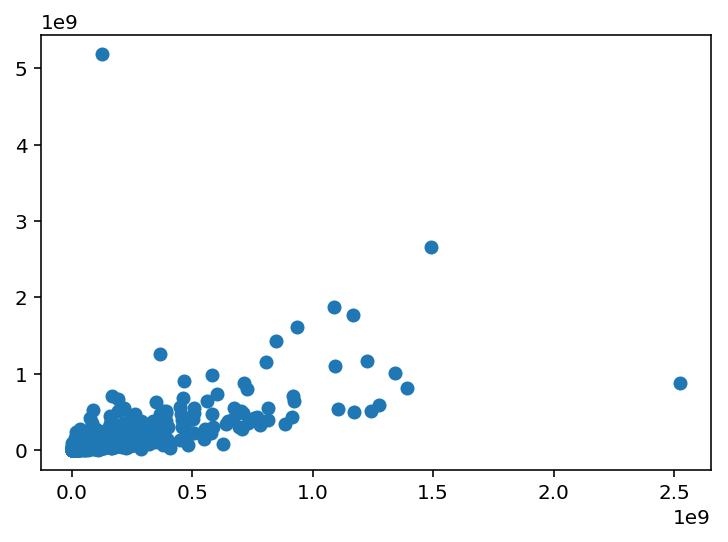

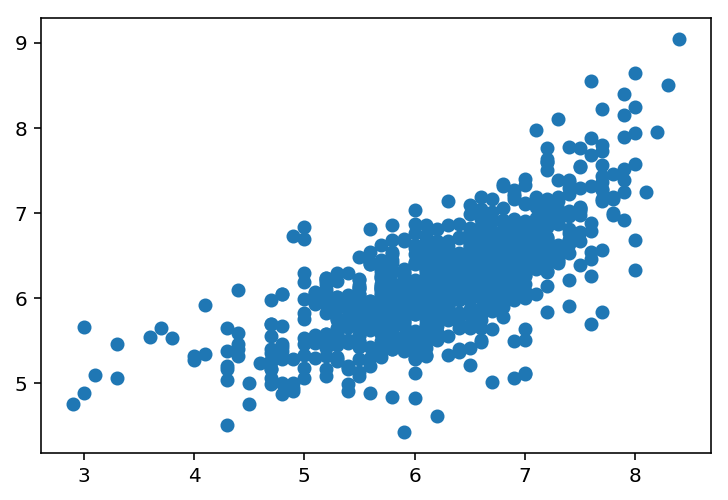

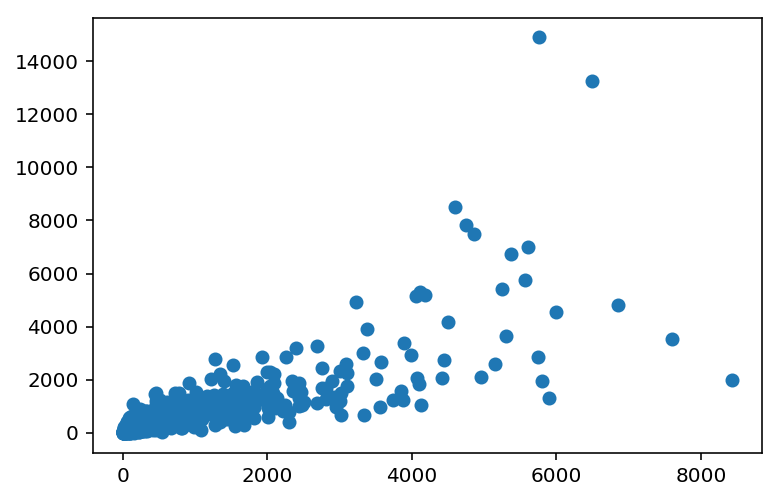

In [36]:
for i, feature in enumerate(features):
    matplotlib.pyplot.scatter(test_sols[i], lasso_preds[i])
    plt.show()

We have a LOT of data. Perhaps if we trim down the results from lasso, our other models will be faster and more accurate.

In [68]:
for i, feature in enumerate(features):
    coef = pd.Series(model_lasso[i].coef_, index = X_train[i].columns)
    cols_to_drop = []
    for c in coef.iteritems():
        if c[1] == 0:
            cols_to_drop.append(c[0])
    train[i] = train[i].drop(cols_to_drop, axis=1)

['aspect_ratio', 'production_countries_', 'production_countries_Afghanistan', 'production_countries_Angola', 'production_countries_Argentina', 'production_countries_Aruba', 'production_countries_Australia', 'production_countries_Austria', 'production_countries_Bahamas', 'production_countries_Belgium', 'production_countries_Bolivia', 'production_countries_Bosnia and Herzegovina', 'production_countries_Brazil', 'production_countries_Bulgaria', 'production_countries_Cameroon', 'production_countries_Canada', 'production_countries_Chile', 'production_countries_China', 'production_countries_Colombia', 'production_countries_Czech Republic', 'production_countries_Denmark', 'production_countries_Dominica', 'production_countries_Ecuador', 'production_countries_Fiji', 'production_countries_Finland', 'production_countries_France', 'production_countries_Germany', 'production_countries_Greece', 'production_countries_Guyana', 'production_countries_Hong Kong', 'production_countries_Hungary', 'producti

,title,vote_average,vote_count,duration,facenumber_in_poster,release_day,release_year,production_countries_United Kingdom,production_countries_United States of America,keywords_duringcreditsstinger,...,Costume Design,Producer,Executive Producer,Hairstylist,Director,Set Decoration,Sound Designer,Animation,Story,Special Effects
0,Avatar,7.2,9.375940,5.187386,0.000000,344,2009,0.693147,1,0.0,...,3,0.693147,0.693147,1.098612,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,Pirates of the Caribbean: At World's End,6.9,8.412055,5.135798,0.000000,139,2007,0.000000,1,0.0,...,2,1.791759,0.693147,0.000000,0.693147,0.693147,0.0,0.000000,0.0,0.0
2,How to Train Your Dragon,7.5,8.349484,4.595120,0.000000,64,2010,0.000000,1,0.0,...,0,0.693147,1.098612,0.000000,1.098612,0.000000,0.0,1.609438,0.0,0.0
3,The Host,6.7,6.287859,4.836282,1.386294,208,2006,0.000000,0,0.0,...,0,0.693147,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,The Host,6.7,6.287859,4.709530,0.000000,208,2006,0.000000,0,0.0,...,1,1.386294,1.609438,0.000000,0.693147,0.000000,0.0,0.000000,0.0,0.0


### Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = []
rf_random = []

for i, feature in enumerate(features):
    rf.append([])
    rf_random.append([])
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf ,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf[i] = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random[i] = RandomizedSearchCV(estimator = rf[i], param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random[i].fit(X_train[i], y[i])
    

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 99.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 135.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 89.9min finished


In [70]:
for i, feature in enumerate(features):
    rf_random[i].best_params_

In [72]:
forest_preds = []
for i, feature in enumerate(features):
    forest_preds.append([])
    
    rf[i] = RandomForestRegressor(n_estimators = 1000, min_samples_split=5, 
                               min_samples_leaf=4, max_features='auto', max_depth=100, bootstrap=True).fit(X_train[i],y[i])
    forest_preds[i] = np.expm1(rf[i].predict(X_test[i]))

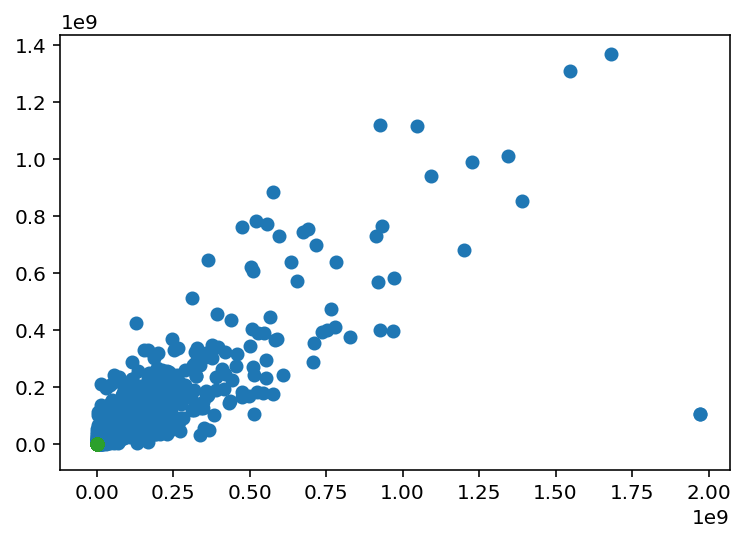

In [73]:
for i, feature in enumerate(features):
    print(feature)
    matplotlib.pyplot.scatter(test_sols[i], forest_preds[i])
    plt.show()

In [76]:
for i, feature in enumerate(features):
    print(feature)
    print(rmse_cv(rf[i], X_train[i], y[i], 10).mean())

revenue
1.5189744654477035
vote_average
0.10471932778400872
vote_count
0.7212016349026438


### XG Boost

In [1]:
import xgboost as xgb

In [3]:
xg = []
xg_sols = []
for i, feature in enumerate(features):
    xg.append([])
    xg_sols.append([])
    
    xg[i] = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 10).fit(X_train[i], y[i])

    xg_sols[i] = np.expm1(xg[i].predict(X_test[i]))

    print(feature)
    matplotlib.pyplot.scatter(test_sols[i], xg_sols[i])
    print(rmse_cv(xg[i], X_train[i], y[i], 10).mean())

NameError: name 'features' is not defined

### Tensor Flow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train.columns)]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(X_train, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(X_test, test_sols, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

test_predictions = model.predict(X_test)

matplotlib.pyplot.scatter(np.expm1(test_sols), test_predictions)